In [1]:
from aais.ibm import mach
from simuq.solver import generate_as
from systems.qaoa import qs
from qiskit.providers.fake_provider import FakeGuadalupe
backend=FakeGuadalupe()

In [2]:
assembly=generate_as(qs, mach, 1)
with open("test.as","w") as f:
    f.write(str(assembly[1])+"\n")
    for item in assembly[2]:
        f.write(str(item)+"\n")
    for item in assembly[3]:
        f.write(str(item)+"\n")




[1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
Init values:  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

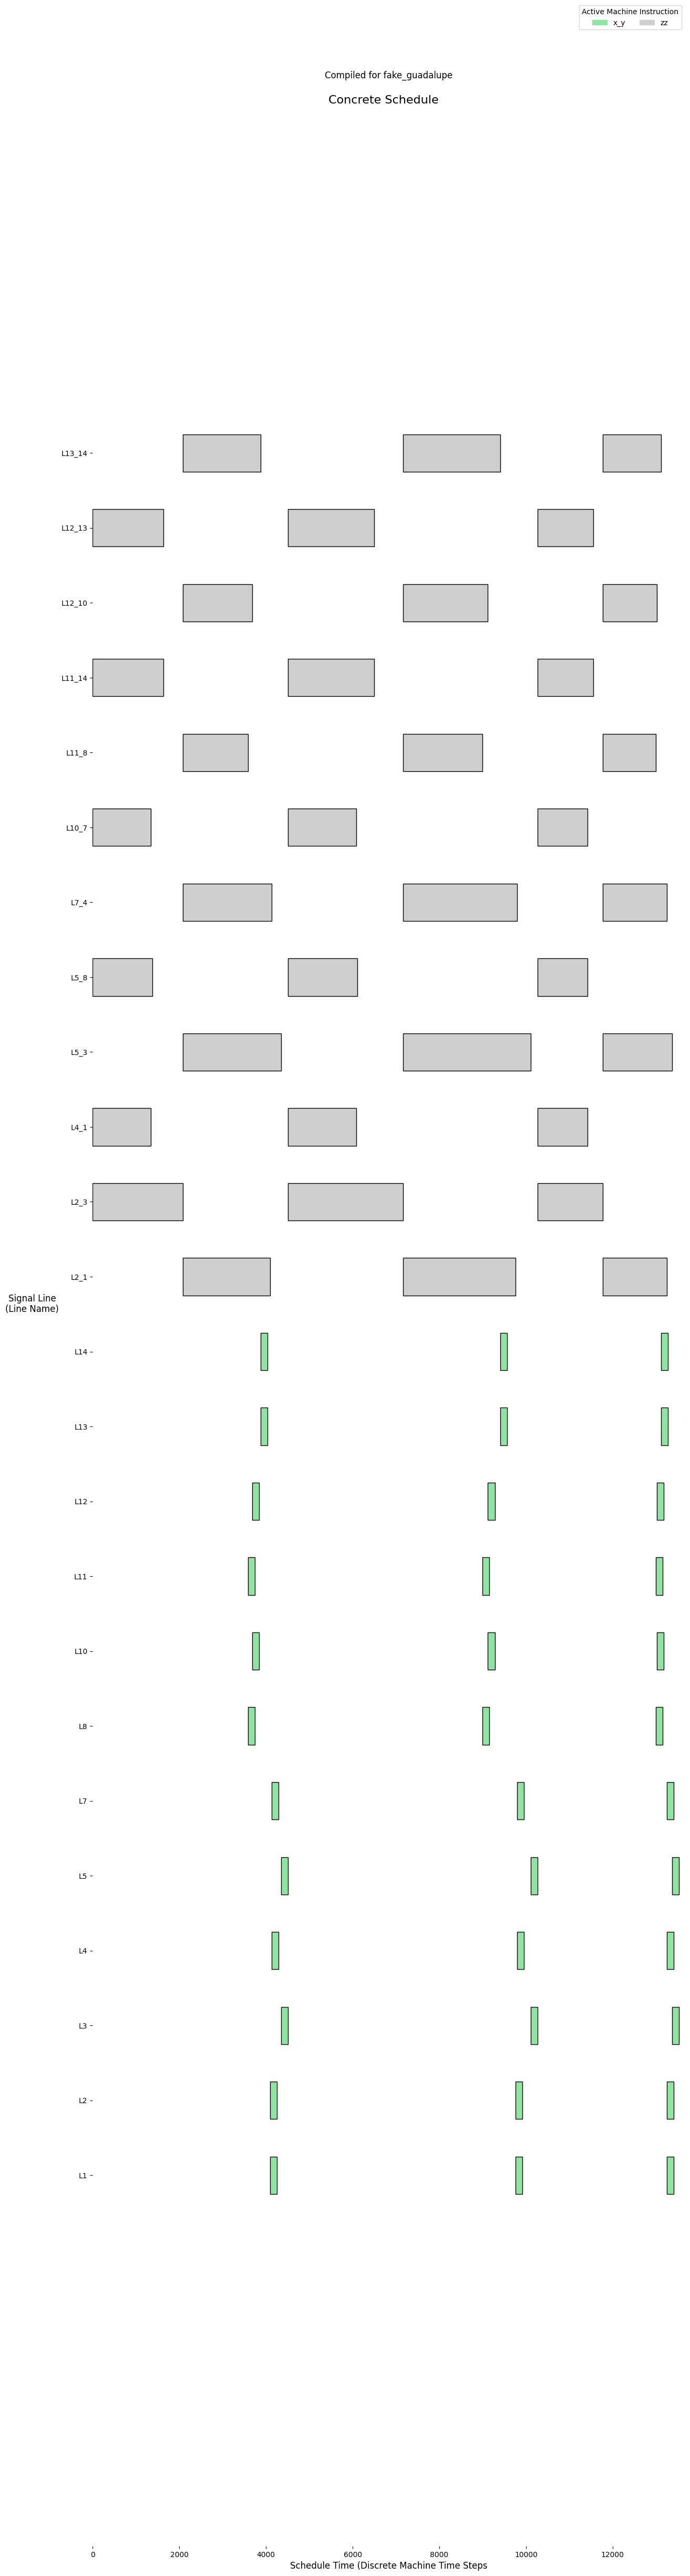

Could not simulate- too many qubits to simulate


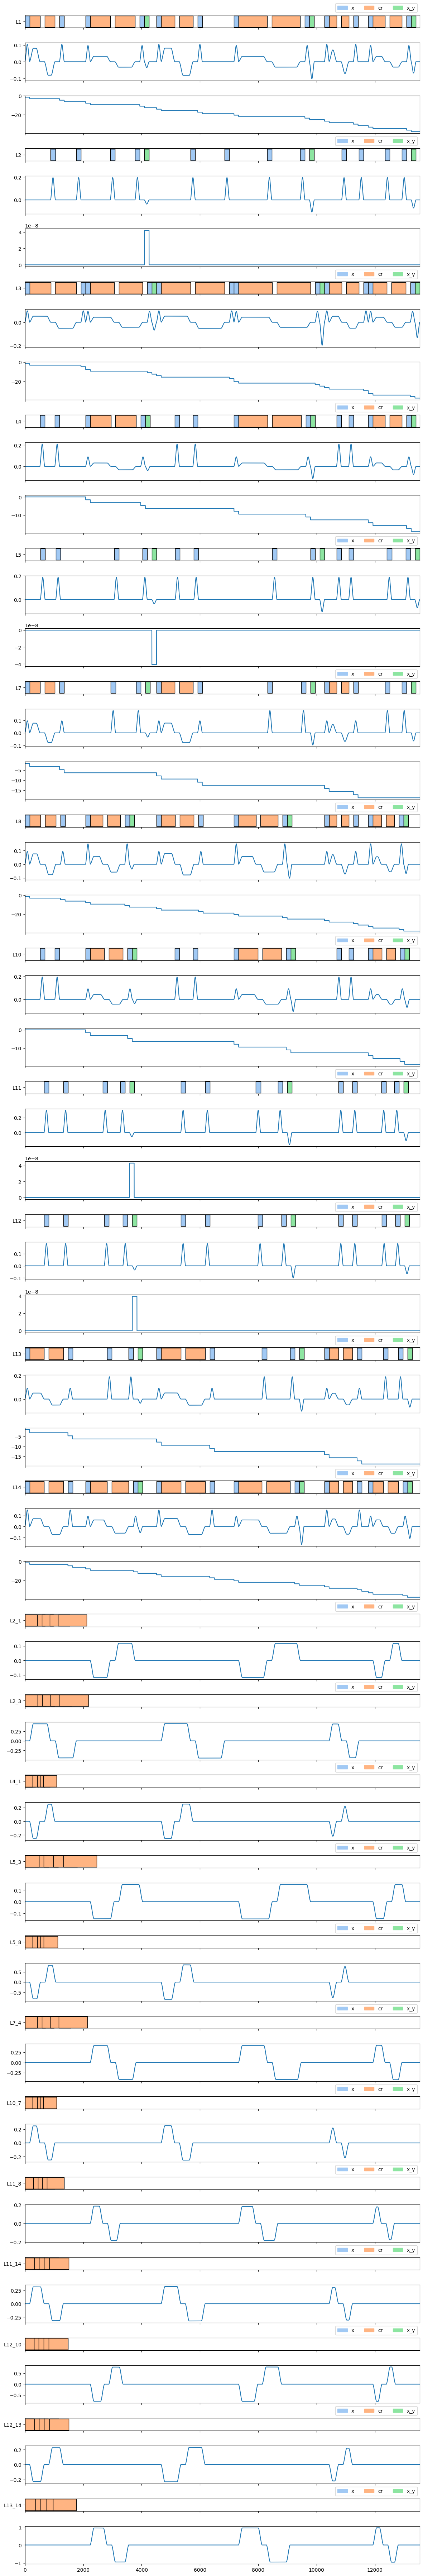

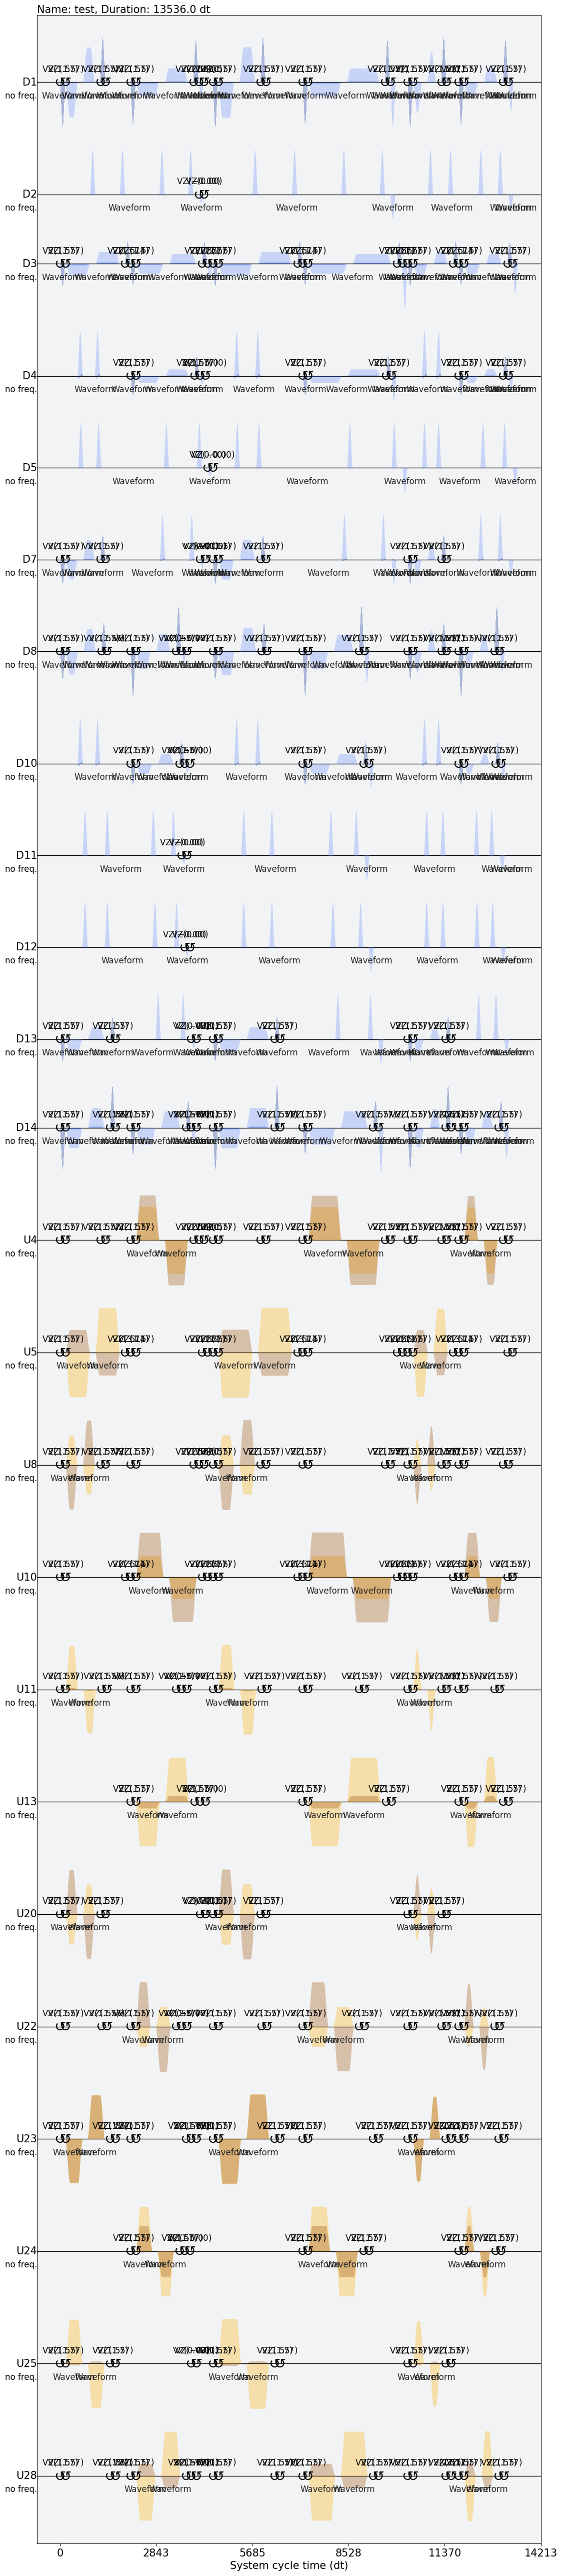

In [3]:
from Analog_Hamiltonian_Simulation.Analog_Hamiltonian_Simulator.IBM_Machine_new import (
    IBM_Machine,
)
from Analog_Hamiltonian_Simulation.Analog_Hamiltonian_Simulator.Program import Program

machine = IBM_Machine(backend)
program = Program(machine)
program.init_from_file("test.as")
# program.init_from_file("Schedules_pengyu/zx_test.as")

#Schedule the instructions greedily using the sorted DAG
program.schedule()

program.concrete_schedule.draw()
program.concrete_schedule.simulate()

#You can use this line to directly access the QuTiP state result from the simulation
#print(program.concrete_schedule.simulation_result)

program.transpile()
program.pulse_schedule.draw()

program.pulse_schedule.generate_external_schedule()
program.pulse_schedule.draw_external_schedule()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


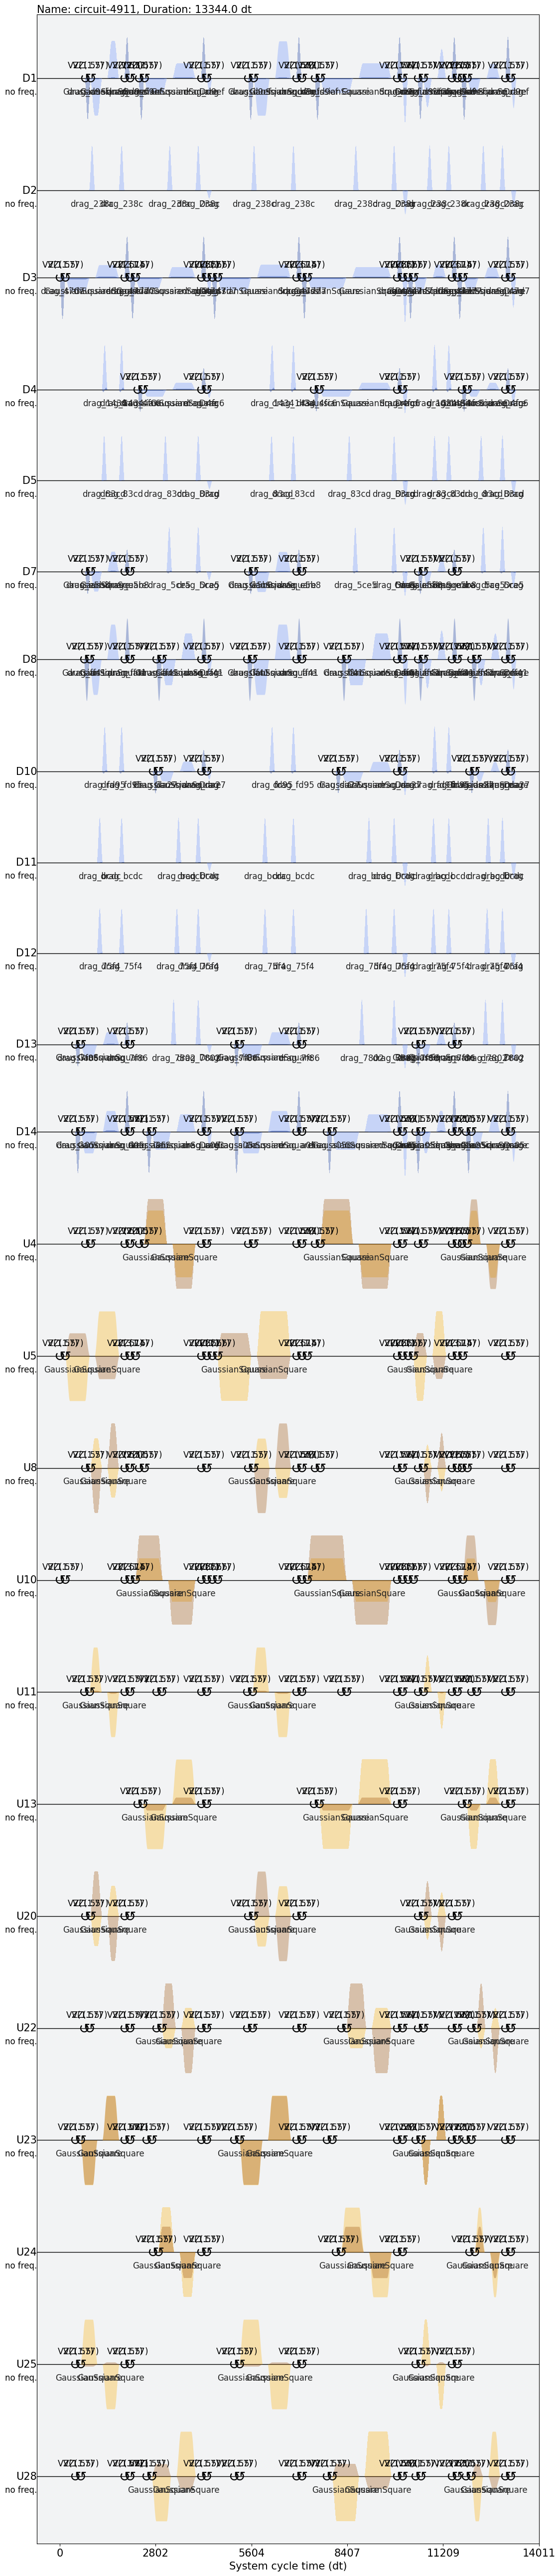

In [41]:
%load_ext autoreload
%autoreload 2
from aais.ibm import mach
from simuq.solver import generate_as
from systems.qaoa import qs
from qiskit.providers.fake_provider import FakeGuadalupe
backend=FakeGuadalupe()
import numpy as np
from qiskit import QuantumCircuit, schedule, transpile
from qiskit.quantum_info import Operator

from Analog_Hamiltonian_Simulation.qiskit_transpiler import get_pm

pm=get_pm(backend)
qc=QuantumCircuit(16)
links=[1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
parameter_list = (
    np.array(
        [
            0.5702193 * 2,
            -0.58631086,
            0.85160685 * 2,
            -1.7058538,
            0.29468536 * 2,
            -1.132814,
        ]
    )
)
for j in range(3):
    for i in range(6):
        qc.rzz(parameter_list[2*j],links[2*i+1],links[(2*i+2)%12])
    qc.barrier()
    for i in range(6):
        qc.rzz(parameter_list[2*j],links[2*i],links[(2*i+1)%12])
    qc.barrier()
    for i in range(12):
        qc.rx(parameter_list[2*j+1],links[i])
    qc.barrier()



qc=pm.run(qc)
qc=transpile(qc,backend)
sched=schedule(qc,backend)
sched.draw()
# qc = QuantumCircuit(2)
# qc.rx(1, 0)
# qc.barrier()
# qc.rxx(1, 0,1)
# qc.barrier()
# qc.ryy(1, 0,1)
# qc.barrier()
# qc.rzz(1, 0,1)
# op1=Operator(qc).data
# qc = pm.run(qc)
# op2=Operator(qc).data
# print(np.linalg.norm(op1-op2))
# print(qc)
# qc = transpile(qc, backend=backend)
# qc = schedule(qc, backend)
# qc.draw()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


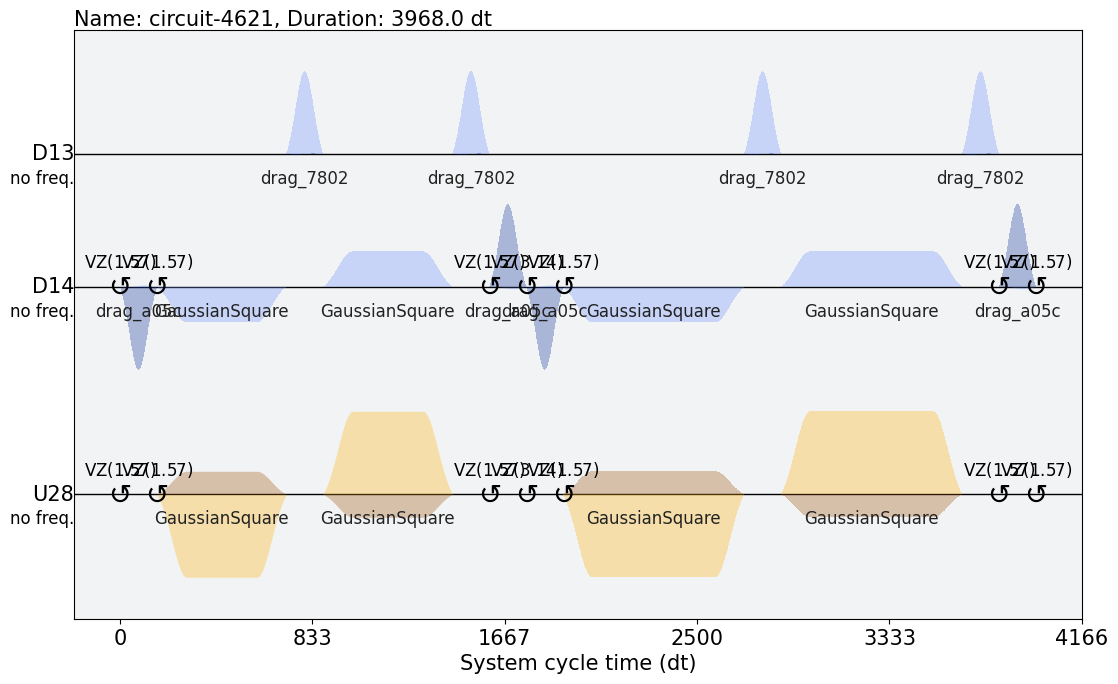

In [36]:
%load_ext autoreload
%autoreload 2
from aais.ibm import mach
from simuq.solver import generate_as
from systems.qaoa import qs
from qiskit.providers.fake_provider import FakeGuadalupe
backend=FakeGuadalupe()
import numpy as np
from qiskit import QuantumCircuit, schedule, transpile
from qiskit.quantum_info import Operator

from Analog_Hamiltonian_Simulation.qiskit_transpiler import get_pm

pm=get_pm(backend)
qc=QuantumCircuit(16)
links=[1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
parameter_list = (
    np.array(
        [
            0.5702193 * 2,
            -0.58631086,
            0.85160685 * 2,
            -1.7058538,
            0.29468536 * 2,
            -1.132814,
        ]
    )
)
for j in range(2):
    # for i in range(6):
    #     qc.rzz(parameter_list[2*j],links[2*i+1],links[(2*i+2)%12])
    # qc.barrier()
    for i in range(3,4):
        qc.rzz(parameter_list[2*j],links[2*i],links[(2*i+1)%12])
    qc.barrier()
    # for i in range(12):
        # qc.x(links[i])
    # qc.x(14)
    # qc.x(13)


qc=pm.run(qc)
qc=transpile(qc,backend)
sched=schedule(qc,backend)
sched.draw()
# qc = QuantumCircuit(2)
# qc.rx(1, 0)
# qc.barrier()
# qc.rxx(1, 0,1)
# qc.barrier()
# qc.ryy(1, 0,1)
# qc.barrier()
# qc.rzz(1, 0,1)
# op1=Operator(qc).data
# qc = pm.run(qc)
# op2=Operator(qc).data
# print(np.linalg.norm(op1-op2))
# print(qc)
# qc = transpile(qc, backend=backend)
# qc = schedule(qc, backend)
# qc.draw()